 <h1><center>Моделирование стоимости автомобилей</center></h1>

## Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак 

    Price — цена (евро)

Алгорит работы:

1. Загрузим и ознакомимся с данными
2. Сделаем предобработку данных
3. Построим несколько моделей и протестируем их на метрике RMSE
4. Общий вывод

## 1. Обзор данных

In [1]:
import urllib.request
import pandas as pd
import time

from os import path
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_name = 'autos.csv'
#download dataset if not existed
if not path.exists(dataset_folder + '/' + dataset_name):
    #create dir if not existed
    Path(dataset_folder).mkdir(parents=True, exist_ok=True)

    #download dataset
    urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                               dataset_folder+'/'+ dataset_name)

df = pd.read_csv(dataset_folder +'/'+ dataset_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Вывод: в данных много ненужных нам признаком, а также имеются пропуски - сделаем предобработку

## 2. Предобработка данных

Дата создания, скачивания анкеты, дата последнего посещение пользователя, кол-во фотографий, почтовый индекс: скорее всего не являются признаками, определяющими стоимость автомобиля - удалим их

In [2]:
df.drop(columns={'DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'}, axis=1, inplace=True)

Проверим

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Поменяем названия колонок на общепринятый тип

In [37]:
df.rename(columns={ 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear':'registration_year',
                    'Gearbox':'gearbox', 'Power':'power', 'Model':'model', 'Kilometer':'kilometer',
                    'RegistrationMonth':'registration_month',  'FuelType':'fuel_type', 'Brand':'brand',
                    'Repaired':'reparied', 'NumberOfPictures':'number_pictures',
                    'PostalCode':'postal_code'}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  Repaired            283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Рассмотрим таргет

<AxesSubplot:>

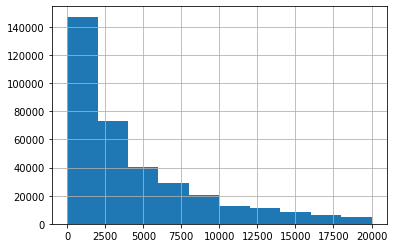

In [6]:
df['price'].hist()


In [7]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

<AxesSubplot:>

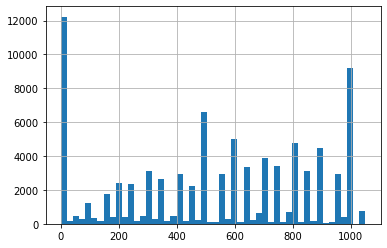

In [8]:
df[df['price'] <= 1050]['price'].hist(bins=50)

<AxesSubplot:>

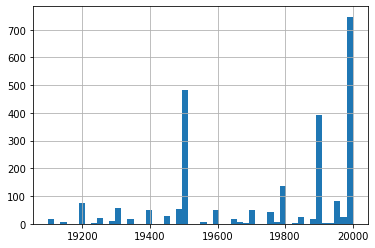

In [9]:
df[df['price'] > 19000]['price'].hist(bins=50)

Есть цены, равные 0, есть цены, упирающиеся в крайние предельное значение 20000. Будем считать их за выборосы и удалим

In [10]:
df = df.loc[(df['price'] >= 500) & (df['price'] < 19500)]

In [11]:
df['price'].describe()

count    316255.000000
mean       4797.835443
std        4370.843365
min         500.000000
25%        1499.000000
50%        3200.000000
75%        6900.000000
max       19499.000000
Name: price, dtype: float64

Рассмотрим год регистрации

<AxesSubplot:>

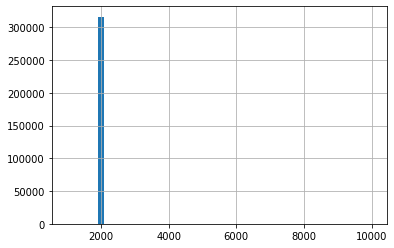

In [12]:
df['registration_year'].hist(bins=50)

In [13]:
df['registration_year'].describe()

count    316255.000000
mean       2004.125902
std          65.199056
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

<AxesSubplot:>

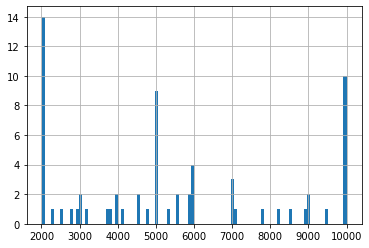

In [14]:
df[df['registration_year'] > 2018]['registration_year'].hist(bins=100)

<AxesSubplot:>

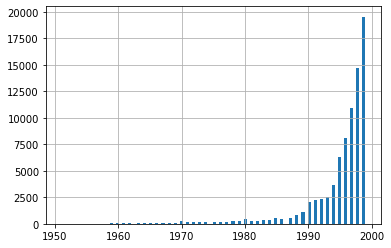

In [15]:
df.loc[(df['registration_year'] < 2000) & (df['registration_year'] > 1950)]['registration_year'].hist(bins=100)

Удалим автомобили с неправильным годом регистрацией, а также датой старше 1960 года. Будем считать их раритетными

In [16]:
df = df.loc[(df['registration_year'] <= 2018) & (df['registration_year'] >= 1960)]

Рассмотрим количественные признаки

<AxesSubplot:>

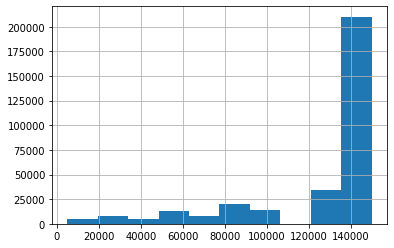

In [17]:
df['kilometer'].hist()

<AxesSubplot:>

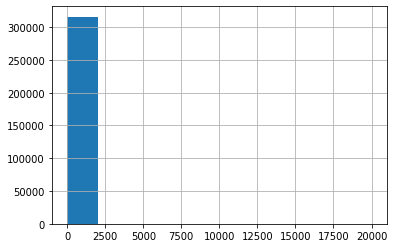

In [18]:
df['power'].hist()

<AxesSubplot:>

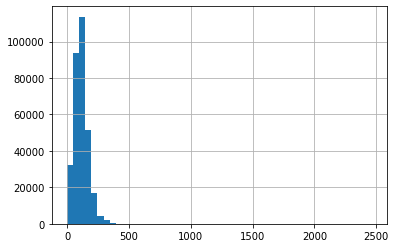

In [19]:
df[df['power'] < 2500]['power'].hist(bins=50)

<AxesSubplot:>

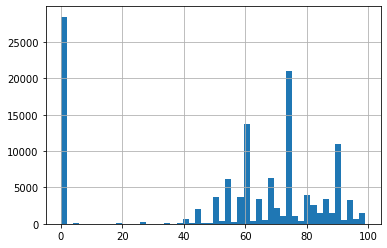

In [20]:
df[df['power'] < 100]['power'].hist(bins=50)

Удалим машины с мощностью ниже 60 и выше 400 лс

In [21]:
df = df[(df['power'] > 60) & ((df['power'] < 400))]

Рассмотрим категориальные признаки

In [22]:
df['vehicle_type'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

<AxesSubplot:>

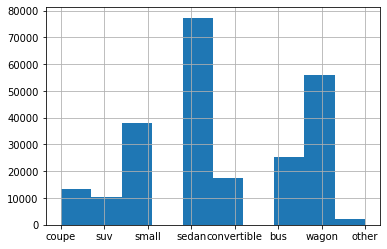

In [23]:
df['vehicle_type'].hist()

Заполним пропуски переменной "other"

In [24]:
df['vehicle_type'].fillna('other', inplace=True)

In [25]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [26]:
df['gearbox'].isna().sum()

4031

Имеющиеся признаки заполним в соотнешние 'auto' к 'manual'

In [27]:
len(df[df['gearbox'] == 'auto']) / len(df[df['gearbox'] == 'manual'])

0.2838625161201531

In [ ]:
gearbox_nan_index = df[df['gearbox'].isna()].index

gearbox_manual_index = gearbox_nan_index[:int(len(gearbox_nan_index)*0.7)]
gearbox_auto_index = gearbox_nan_index[int(len(gearbox_nan_index)*0.7):]

df['gearbox'].loc[gearbox_manual_index] = 'manual'
df['gearbox'].loc[gearbox_auto_index] = 'auto'

df['gearbox'].isna().sum()

Рассмотрим признак названия модели

In [29]:
df['model'].value_counts()

golf                  23257
other                 18101
3er                   17130
a4                     8663
passat                 8662
                      ...  
rangerover                3
serie_3                   3
range_rover_evoque        2
samara                    2
seicento                  2
Name: model, Length: 247, dtype: int64

In [30]:
df['model'].isna().sum()

9293

Заполним пропуски значением 'other'

In [31]:
df['model'].fillna('other', inplace=True)
df['model'].isna().sum()

0

Рассмотрим признак, исспользуемого типа топлива

In [32]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заполним пропуски значением 'other'

In [33]:
df['fuel_type'].fillna('other', inplace=True)
df['fuel_type'].isna().sum()

0

Рассмотрим бинарные признак, характеризующий, была ли машина в ремонте

In [38]:
df['reparied'].unique()

array(['yes', nan, 'no'], dtype=object)

In [39]:
df['reparied'].value_counts()

no     199764
yes     21192
Name: reparied, dtype: int64

По аналогии заполним пропуски в соотношение имеющихся значений

In [40]:

len(df[df['reparied'] == 'no']) / len(df[df['reparied'] == 'yes'])

9.42638731596829

In [ ]:
rep_index = df[df['reparied'].isna()].index

rep_yes_index = rep_index[:int(len(rep_index)*0.9)]
rep_no_index = rep_index[int(len(rep_index)*0.9):]

df['reparied'].loc[rep_no_index] = 'no'
df['reparied'].loc[rep_yes_index] = 'yes'

df['reparied'].isna().sum()

Рассмотри признак месяца регистрации

In [44]:
df['registration_month'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

<AxesSubplot:>

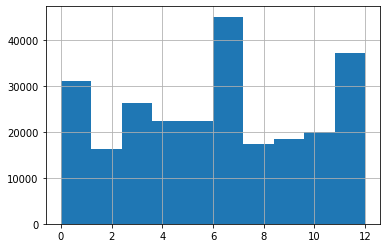

In [45]:
df['registration_month'].hist()

Удалим дупликаты

In [46]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235592 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               235592 non-null  int64 
 1   vehicle_type        235592 non-null  object
 2   registration_year   235592 non-null  int64 
 3   gearbox             235592 non-null  object
 4   power               235592 non-null  int64 
 5   model               235592 non-null  object
 6   kilometer           235592 non-null  int64 
 7   registration_month  235592 non-null  int64 
 8   fuel_type           235592 non-null  object
 9   brand               235592 non-null  object
 10  reparied            235592 non-null  object
dtypes: int64(5), object(6)
memory usage: 21.6+ MB


Как мы видим датасет сильно сократился. Посмотрим сколько данных потеряно

In [47]:
print(235592/354368)

0.6648230088495575


Около 35% изначальных данных

Вывод: мы провели предобработку данных, убрали выборосы и заменили пропуски

## 3. Построение моделей

Выделим таргет и признаки

In [48]:
y = df['price']
X = df.drop('price', axis=1)

Выделим количественные и категориальные признаки

In [51]:
num_cols = ['kilometer', 'power']
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'reparied']

In [53]:
X[cat_cols] = X[cat_cols].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235592 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        235592 non-null  category
 1   registration_year   235592 non-null  int64   
 2   gearbox             235592 non-null  category
 3   power               235592 non-null  int64   
 4   model               235592 non-null  category
 5   kilometer           235592 non-null  int64   
 6   registration_month  235592 non-null  int64   
 7   fuel_type           235592 non-null  category
 8   brand               235592 non-null  category
 9   reparied            235592 non-null  category
dtypes: category(6), int64(4)
memory usage: 10.6 MB


Поделим выборку на тестовую и обучающую

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
display(len(X_train)/len(X_test))
display(len(y_train)/len(y_test))

3.0

3.0

Сделаем преобразования наших данных. OHE для категориальных. MinMaxScaler для числовых. Будем делать преобразование во всех пайплайнах, кроме lgmlight

In [55]:
pipelines = []
params = []

cat_transformer_linear = OneHotEncoder(handle_unknown='ignore')
num_transformer_linear = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer_linear, num_cols),
        ("cat", cat_transformer_linear, cat_cols)
    ]
)


Сделаем 3 пайплайна:
1. Для деревянных моделей
2. Для lgmlight модели
3. Для линейной регрессии

Для деревянных моделей понизим размерность признаков до 5. Для линейных моделей посмотрим, что будет с результатом, если повышать размерность признаков.

In [56]:
pipeline_tree = Pipeline([('preprocessor_linear', preprocessor), ('trun_svd', TruncatedSVD(n_components=5)),
                          ('tree', None)])

pipeline_lgm = Pipeline([('lgm', None)])

pipeline_linear = Pipeline([('preprocessor_linear', preprocessor), ('trun_svd', TruncatedSVD()), ('linear', None)])

Сделаем 5 сетов параметров:
1. Для деревянных моделей с перебором гиперпараметров
2. Для деревянных моделей с параметрами по-умолчанию
3. Для lgmlight модели с перебором гиперпараметров
4. Для lgmlight модели с параметрами по-умолчанию
5. Для линейной регрессии с перебором параметра понижения размерности 

In [57]:
param_tree = [
    {'tree': (DecisionTreeRegressor(random_state=1),),
     'tree__max_depth': range(1, 20, 5),
     },

    {'tree': (RandomForestRegressor(random_state=1),),
     'tree__n_estimators': range(1, 20, 5),
     'tree__max_depth': range(1, 20, 5),
     }
]

param_tree_default = [
    {'tree': (DecisionTreeRegressor(random_state=1),),
     },

    {'tree': (RandomForestRegressor(random_state=1),),
     }
]

param_lgm = [
    {'lgm': (LGBMRegressor(random_state=1),),
     'lgm__n_estimators': range(1, 20, 5),
     'lgm__max_depth': range(1, 20, 5),
     }
]

param_lgm_default = [
    {'lgm': (LGBMRegressor(random_state=1),),
     }
]

param_linear = [
    {   'linear': (LinearRegression(),),
        'trun_svd__n_components': [5, 30, 50]
     }
]

Сделаем из них списки. Создадим список names с описанием каждого процесса

In [58]:
pipelines = [pipeline_tree, pipeline_lgm, pipeline_linear, pipeline_tree, pipeline_lgm]
param_grids = [param_tree, param_lgm, param_linear, param_tree_default, param_lgm_default]
names = ['tree', 'lgm', 'linear_reg', 'default_tree', 'default_lgm']

Напишем функцию, которая принимает пайплайн и параметры и выводит:
1. Таблицу лучших моделей
2. Результат лучшей модели на кросс валидации
3. Результат лучшей модели на тест семпле
4. Время предикшина лучшей модели на тест семпле

In [59]:
def gs_and_result(pipeline, param_grid, name):
    gs = GridSearchCV(pipeline,
                      param_grid,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=10,
                      refit='neg_root_mean_squared_error',
                      cv=5)

    #fit
    gs.fit(X_train, y_train)

    #top models table
    print('Top ' + name + ' models:')
    results_df = pd.DataFrame(gs.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    display(results_df[['params', 'mean_test_score', 'mean_fit_time', 'rank_test_score']]
            .head(5)
            .rename(columns={'mean_test_score': 'cv_score'})
            .rename(columns={'rank_test_score': 'rank_cv_score'}))

    #best cv score
    print('best cv score of ' + name + ' model:')
    print(gs.best_score_)

    #test score of best estimator + time prediction calculation
    print('Test ' + name + ' score:')
    start = time.time()
    print(mean_squared_error(y_test, gs.best_estimator_.predict(X_test), squared=False))
    pred_time = time.time() - start

    #time prediction speed of best estimator
    print('Prediction time best ' + name + ' model:')
    print(pred_time)   
    print()
    print()     

    return gs        

Запустим и посмотрим, что получилось

In [60]:
results = []
for pipeline, param_grid, name in zip(pipelines, param_grids, names):   
    results.append(gs_and_result(pipeline, param_grid, name))            

Top tree models:


,params,cv_score,mean_fit_time,rank_cv_score
19,"{'tree': RandomForestRegressor(max_depth=16, n...",-2575.037569,10.370398,1
18,"{'tree': RandomForestRegressor(max_depth=16, n...",-2592.311206,8.803399,2
17,"{'tree': RandomForestRegressor(max_depth=16, n...",-2636.502965,5.382199,3
3,{'tree': DecisionTreeRegressor(random_state=1)...,-2904.937550,2.219403,4
15,"{'tree': RandomForestRegressor(max_depth=16, n...",-2963.661635,10.415998,5


best cv score of tree model:
-2575.037568977456
Test tree score:
2560.7941530081343
Prediction time best tree model:
0.17599797248840332


Top lgm models:


,params,cv_score,mean_fit_time,rank_cv_score
11,"{'lgm': LGBMRegressor(max_depth=11, n_estimato...",-2119.846525,0.478001,1
15,"{'lgm': LGBMRegressor(max_depth=11, n_estimato...",-2119.846525,0.403398,1
7,"{'lgm': LGBMRegressor(max_depth=11, n_estimato...",-2124.611178,0.469399,3
10,"{'lgm': LGBMRegressor(max_depth=11, n_estimato...",-2447.438793,0.402799,4
14,"{'lgm': LGBMRegressor(max_depth=11, n_estimato...",-2447.438793,0.419598,4


best cv score of lgm model:
-2119.846525139351
Test lgm score:
2148.7776591424267
Prediction time best lgm model:
0.01999950408935547


Top linear_reg models:


,params,cv_score,mean_fit_time,rank_cv_score
2,"{'linear': LinearRegression(), 'trun_svd__n_co...",-3009.286064,9.390399,1
1,"{'linear': LinearRegression(), 'trun_svd__n_co...",-3260.069737,6.354203,2
0,"{'linear': LinearRegression(), 'trun_svd__n_co...",-3931.445235,1.790403,3


best cv score of linear_reg model:
-3009.286064275143
Test linear_reg score:
3031.113005537422
Prediction time best linear_reg model:
0.07299995422363281


Top default_tree models:


,params,cv_score,mean_fit_time,rank_cv_score
1,{'tree': RandomForestRegressor(random_state=1)},-2440.428383,67.464199,1
0,{'tree': DecisionTreeRegressor(random_state=1)},-2850.477233,2.900599,2


best cv score of default_tree model:
-2440.428383466876
Test default_tree score:
2411.5715400761515
Prediction time best default_tree model:
1.2589950561523438


Top default_lgm models:


,params,cv_score,mean_fit_time,rank_cv_score
0,{'lgm': LGBMRegressor(random_state=1)},-1654.45482,1.020999,1


best cv score of default_lgm model:
-1654.4548195999444
Test default_lgm score:
1674.7686789502502
Prediction time best default_lgm model:
0.07100081443786621




## Общий вывод

Мы провели исследование клиентской базы сервиса по продаже автомобилей «Не бит, не крашен». Целью работы было построение модели прогнозирующей стоимость автомобиле исходя из его характеристик. Меняя модели и их гиперпараметры, мы старались получить максимальный показатель RMSE, скорости тренировки модели и скорости предсказания. По результатам исследования LGBMLight с дефолтными характеристиками показала наилучший результат:

LGBMRegressor(n_estimators=100, learning_rate=0.1):
-   RMSE cv:          1654
-   RMSE test:        1674
-   fit time:         0.92
-   prediction time:  0.08
